# 1 Intro to this Notebook

This Jupyter notebook calculates the comercial and residential building stock turnover based on equations and data from Tamara Knittel's work and research and is implemented as a part of the ECE 499 capstone project from the University of Victoria.


In [60]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt

## 1.1 Data manipulation

The cell below extracts the relevant data from the Excel spreadsheet of interest

In [61]:
stock_file = '../Documents_and_References/Stock_Formatted_Data_File.xlsx' # Paste here the relative address to the datasheet
stock_data = pd.DataFrame(pd.read_excel(stock_file, sheet_name="Input"))

# Global variables
included, Year, Demo_b, New_b, Retro_b, EUI, PG = stock_data.T.values # Get rates from data
EUI_history = [0.48, 0.43, 0.36, 0.29, 0.24, 0.19, 0.19, 0.16, 0.15, 0.14] # EUI for historical vintages

# 2 Vintages

A vintage is a period of a number of years for which the building stock undergoes changes in composition based on the changes suffered by the stock in a previous vintage. That is, each vintage is affected by a previous, historic, vintage. If a vintage is a collection of 10 years, for example, then we will group the next 10 years of the building stock into a new vintage. 

The retrofit rate can be applied differently for different vintages based on the scenario we are choosing to address. Ex.: we can choose to retrofit 5% of buildings from the 1970's and 3% of buildings from the 1950's for our new stock in, say 2016-2025. The same is true for the demolition rate.


## 2.1 Vintages Coding Approach

Here the choice of coding strategy is to create a `class` for the vintages which will have a series of member functions that will calculate the following quantities for that time period:

* The total floor space (Eq. 21 together with Eq. 31)
* The average EUI of the vintage (Eq. 13)
* The remaining area per vintage (Eq. 25)
* Space heating energy demand for the vintage (Eq.27-30)
  
Additional methods are established to:

* Reset the vintage period
* Add members to an existing vintage
* Display building stock for the vintage




In [62]:
# Create vintages as a class

class Vintage:
    # Class to create a vintage period for building stock
    # A vintage period is a short time series which captures the total, 
    # new construction, demolished, and retrofitted floor space for a number of years
    
    def __init__(self, s_year, starting_building_stock=295.745, remaining_start_stock=281) -> None:
        # Class initializer (all class attributes are declared here)
        # The initial building stock given by default is from 2016
        
        self.__vintage_history = pd.DataFrame(columns=['Years', 'New', 'Demolished', 'Retrofitted', 'Total', 'Average EUI']) # Dictionary with all vintages created
        self.__vintage = [] # Years in vintage period
        self.__demo_FS = [] # Demolished floor space in vintage periiod
        self.__retro_FS = [] # Retrofitted floor space in vintage period
        self.__new_FS = [] # New construction (floor space) in vintage period
        self.__total_FS = [] # Total floor space in vintage period
        self.__historical_FS = [8.369309574, 10.53901598, 37.9964877, 35.23895826, 59.0961685, 23.70776522,
                                	24.33461767, 30.60991933, 25.99295, 16.90715]

        self.__space_HD = [] # Space heat demand for vintage period
        #self.__water_HD = [] # Water heat demand for vintage period

        self.__start_year = s_year # First year of vintage period
        self.__starting_stock = starting_building_stock
        self.__remaining_stock = [remaining_start_stock]

        
        self.__population = 4859250 # Initial population to the model
        self.__reference_FS = 10.85 * self.__population  # Reference floor space (from 1946-1960)
        self.__total_area = 58.7 # Total floor space at start
        self.__SH_start = 71.53  # Space heat demand at start
        
    def reset_vintage(self, new_start, new_stock):
        # Method for resetting the vintage periods
        self.__init__(new_start, new_stock)

    def add_to_vintage(self,vin_end):
        # This method adds years to the vintage period until vintage end (vin_end)
        curr_year = self.__start_year

        while curr_year <= vin_end:
            self.__vintage.append(curr_year)
            curr_year += 1
    #######################################################################################################################

    # Simple getter to obtain list of all included years.
    def get_vintage(self):
        return self.__vintage
        
    # Calculate the total, newly built, retrofitted, and demolished floor spaces (all are calculated in this single function)
    # Corrsponds to: Eq 31 - Verifyed and correct!!
    def add_FS(self, return_FS = False, return_FS_type="total"):
        y = self.__start_year # Placeholder year
        current_stock, remaining_stock_start, current_pos = self.__starting_stock, self.__remaining_stock[-1], 0
        Anew, Aretro, Ademo = current_stock, 0, current_stock # Starting values for new, retrofitted, and demolished construction
        

        while y <= self.__vintage[-1]: # Get last year of vintage period
            self.__total_FS.append(current_stock)

            nc_rate, retro_rate, demo_rate = New_b[current_pos], Retro_b[current_pos], Demo_b[current_pos]

            Anew = abs(current_stock/100 * nc_rate) # Update new construction
            self.__new_FS.append(Anew)

            Ademo = abs(current_stock/100 * demo_rate) # Update demolished floor space
            self.__demo_FS.append(Ademo)

            remaining_stock_start = remaining_stock_start - Ademo # Update remaining stock for the next year (Eq. 25)
            self.__remaining_stock.append(remaining_stock_start) 

            Aretro = abs(remaining_stock_start/100 * retro_rate) # Update retrofitted floor space
            self.__retro_FS.append(Aretro)


            current_stock = round(current_stock + Anew - Ademo, 2) # Update current building stock: current = current total - demolished + new construction  

            y += 1 # Go to next year
            self.__population = self.__population * PG[current_pos] # Update population for next year
            current_pos += 1 # update position for data frames

        # Adding the if-else statement to check whether to return the FS or not
        # If the argument passed as True to return FS, check what kind of FS
        if return_FS == True:
            # if the return type is total, return the total FS
            if return_FS_type == "total":
                return self.__total_FS
            
            # if return type is new, return the new FS
            elif return_FS_type == "new":
                return self.__new_FS
            
            # if return type is demo, return the demolished FS
            elif return_FS_type == "demo":
                return self.__demo_FS
            
            # if return type is retro, return the retrofitted FS
            elif return_FS_type == "retro":
                return self.__retro_FS
            else:
                assert return_FS_type in ['new', 'demo', 'retro']

    def change_vintage_period(self, new_y, new_end_y):
        # This method creates a new vintage from scratch with the new start and end years given to it
        
        EUI_current = sum(self.__total_FS * EUI[:(self.__vintage[-1] - self.__start_year)+1]) / sum(self.__total_FS)

        self.__vintage_history.loc['Vintage ' + str(self.__vintage[0]) + 
        ' - ' + str(self.__vintage[-1])] = [self.__vintage, self.__new_FS, self.__demo_FS, self.__retro_FS, self.__total_FS, EUI_current]
        
        #print(self.__vintage_history["Total"].iloc[-1][-1])
        self.reset_vintage(new_start=new_y, new_stock=self.__vintage_history["Total"].iloc[-1][-1]) # Create new vintage using the last vintage's last building stock as starting stock
        self.add_to_vintage(new_end_y)
        self.add_FS()


    def check_vintage(self, type="total", current=True):
        # Method for displaying current building stock for each vintage type
        print("Measurements are given in squared meters \n")
        if current == True:
            if type == "total":
                print("\nTotal floor space per year in vintage ", self.__vintage[0], " - ", self.__vintage[-1],
                    "is: ", self.__total_FS)
            elif type == "new":
                print("\nTotal new floor space per year in vintage ", self.__vintage[0], " - ", self.__vintage[-1],
                    "is: ", self.__new_FS)
            elif type == "retrofit":
                print("\nTotal retrofitted floor space per year in vintage ", self.__vintage[0], " - ", self.__vintage[-1],
                    "is: ", self.__retro_FS)
            else:
                print("Unrecognized type of floor space. Did you mean 'new', 'retrofit', or 'total' instead?")
        else:
            print(self.__vintage_history)
    
    # Calculate the average energy use intensity for each year of our forecast. Corresponds to Eq. 13 
    # Verifyed and correct !! However the rounding errors from floor space calculations are causing errors here (order of 4-6%)
    def get_avg_EUI(self, vintage_type="total"):
        
        EUI_avg = []
        for total_fs in self.__total_FS:
            # Implement Eq. 13
            eui =  0.171 * sum(self.__new_FS)  + 0.171 * sum(self.__retro_FS) + sum(self.__historical_FS[i]*EUI_history[i] for i in range(len(EUI_history))) 
            EUI_avg.append(eui / total_fs)
        
        # Return the average EUI array
        return EUI_avg 



    def Demand(self, demand_from = "total"):

        #print("Length: ", len(self.__vintage))
        SH_retro = []
        SH_new = []
        SH_remain = []
        

        eui = self.get_avg_EUI()

        for n in range(len(self.__vintage)):
            
            try:
                 sh_retro = self.__retro_FS[n] * EUI_history[n] # Eq.27
            except(IndexError):
                 sh_retro = self.__retro_FS[n] * 0.171 # Eq.27
            
            SH_retro.append(sh_retro)
            

            sh_new = self.__new_FS[n] * eui[n] # Eq.28
            SH_new.append(sh_new)
            
            sh_rem = self.__remaining_stock[n] * eui[n] # Eq.29
            SH_remain.append(sh_rem)

            self.__space_HD.append(sh_retro + sh_new + sh_rem) # Eq.30

        '''
        SH_remaining = sum(self.__retro_FS[i] * EUI_history[i] for i in range(len(self.__vintage))) # Eq.27
        SH_new = sum(self.__new_FS[n] * eui[n]  for n in range(len(self.__vintage))) # Eq. 28
        SH_retro = sum( self.__remaining_stock[n] * eui[n] for n in range(len(self.__vintage))) # Eq. 29

        self.__space_HD = SH_new + SH_remaining + SH_retro # total space heat demand (Eq. 30)
        '''
        if demand_from == "remaining":
                return SH_remain
        elif demand_from == "new":
                return SH_new
        elif demand_from == "retro" or demand_from == "retrofitted":
                return SH_retro
        elif demand_from == "total":
                return self.__space_HD




    def test(self, y_end=2050, v_type="total"):
        print("-"*10)

        self.add_to_vintage(y_end)


        self.add_FS()
        eui_avg = self.get_avg_EUI()
        self.check_vintage(v_type)

        d_type = "total"
        demand_test = self.Demand(d_type)

       
        print("New ", self.__new_FS)
        print("Demo ", self.__demo_FS)
        print("Retro ", self.__retro_FS)
        print("Total ", self.__total_FS)
 
        #print("EUI for historical vintages", EUI_history)
        print("\nThe average EUI for total floor space in the period between ", self.__start_year, " and ", self.__vintage[-1], " is: ", eui_avg)
        
        print("-"*10)
        print("Space heat demands: \n")
        print("Range: ", self.__start_year, " - ", self.__vintage[-1], "\n")
        print("Demand for ", d_type, " is: ", demand_test, "\n")
        print("Total space heat demand per year is: ", self.__space_HD)

## 2.3 Class Test 

Testing block

In [63]:
my_vintage = Vintage(2016)

my_vintage.test(2020, "total")
'''
my_vintage.add_to_vintage(2020)


my_vintage.add_FS()
my_vintage.get_avg_EUI()
my_vintage.check_vintage("total")

'''
print("-" * 20)

# # create another vintage for testing the argument for the add_FS method
# my_vintage_2 = Vintage(2016)
# my_vintage_2.add_to_vintage(2020)
# FS_my_vintage_2 = my_vintage_2.add_FS(True)

# print(FS_my_vintage_2)

# print("-" * 20)

----------
Measurements are given in squared meters 


Total floor space per year in vintage  2016  -  2020 is:  [295.745, 299.0, 302.29, 305.62, 308.98]
New  [4.436175, 4.485, 4.534350000000001, 4.5843, 4.6347000000000005]
Demo  [1.1829800000000001, 1.1960000000000002, 1.2091600000000002, 1.22248, 1.2359200000000001]
Retro  [6.9954255, 6.965525499999999, 6.9352965, 6.904734499999999, 6.8738364999999995]
Total  [295.745, 299.0, 302.29, 305.62, 308.98]

The average EUI for total floor space in the period between  2016  and  2020  is:  [0.2594413445864512, 0.25661699148735784, 0.2538240777224519, 0.25105844007172307, 0.24832830751090684]
----------
Space heat demands: 

Range:  2016  -  2020 

Demand for  total  is:  [77.41174927561359, 75.95190501117864, 74.36835738240963, 72.79988904081603, 71.3862892547075] 

Total space heat demand per year is:  [77.41174927561359, 75.95190501117864, 74.36835738240963, 72.79988904081603, 71.3862892547075]
--------------------


# 3 Visuals

The next portion of code is related to visualizing results. (Sample graphs Fig. 1)

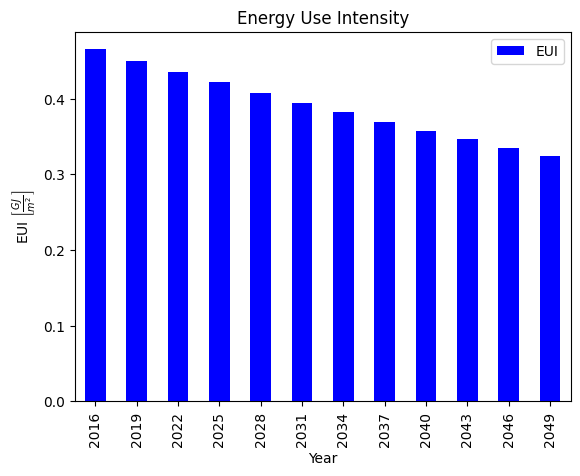

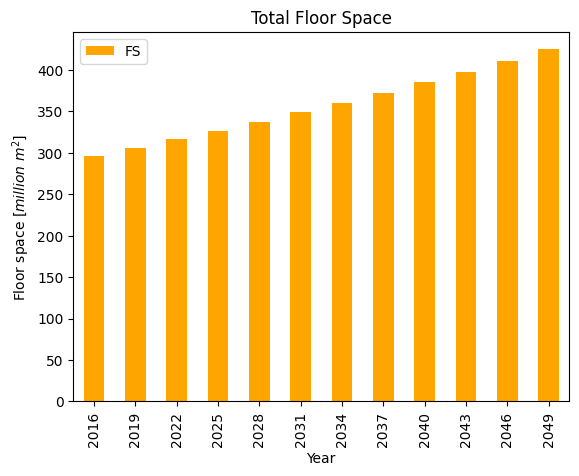

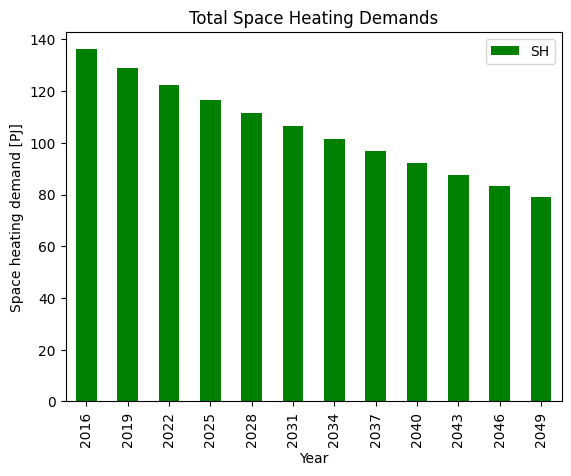

In [64]:
# Visualization class wrapper

class Visualizer(Vintage):

    def __init__(self, s_year, end_year, eui_col="blue", fs_col="orange", sh_col="green", starting_building_stock=295.745, remaining_start_stock=281):
        super().__init__(s_year, starting_building_stock, remaining_start_stock)

        self.add_to_vintage(end_year)
        self.__vintage = self.get_vintage()

        # Create lists for the relevant data.
        # NOTE: The SH calculation is invalid. Remaining in as temp placeholder
        self.__FS = self.add_FS(True, "total")
        self.__EUI = self.get_avg_EUI()
        self.__SH = self.Demand("total")

        # Visualization options
        self.__eui_col = eui_col
        self.__fs_col = fs_col
        self.__sh_col = sh_col

        self.set_data()


    def set_data(self):
        self.__data = {
            'VIN' : self.__vintage,
            'EUI' : self.__EUI,
            'FS' : self.__FS,
            'SH' : self.__SH
        }
    
    # Take input data (one element per year) and change it to (one element per res years) by selection 
    def align_data(self, align=5):
        tmp_array = self.__vintage
        tmp_len = len(tmp_array)
        
        indices = [i for i in range(tmp_len) if not tmp_array[i] % align]

        self.__vintage = [self.__vintage[i] for i in indices]
        self.__FS = [self.__FS[i] for i in indices]
        self.__EUI = [self.__EUI[i] for i in indices]
        self.__SH = [self.__SH[i] for i in indices]

        self.set_data()


    # plotting functions
    def plot_EUI(self):
        df = pd.DataFrame(self.__data)
        df.plot(x='VIN', y='EUI', kind='bar', color=self.__eui_col)

        plt.title("Energy Use Intensity")
        plt.xlabel("Year")
        plt.ylabel("EUI $\\left[\\frac{GJ}{m^2}\\right]$")

        plt.show()

    def plot_FS(self):
        df = pd.DataFrame(self.__data)
        df.plot(x='VIN', y='FS', kind='bar', color=self.__fs_col)

        plt.title("Total Floor Space")
        plt.xlabel("Year")
        plt.ylabel("Floor space $\\left[million\\ m^2\\right]$")

        plt.show()

    def plot_SH(self):
        df = pd.DataFrame(self.__data)
        df.plot(x='VIN', y='SH', kind='bar', color=self.__sh_col)

        plt.title("Total Space Heating Demands")
        plt.xlabel("Year")
        plt.ylabel("Space heating demand [PJ]")

        plt.show()

    # TODO: other types of graphs

# When the frontend requires an image, the following commands are used

# Define requested visualization by generating dataset using end years
v = Visualizer(2016, 2050, eui_col="blue", fs_col="orange", sh_col="green")

# Optional: Align data
v.align_data(3)

# Plot the requested graph(s).
v.plot_EUI()
v.plot_FS()
v.plot_SH()